# Determining Starbucks Demographics

In this notebook I will use the data cleaning performed in the processing notebook to attempt to determine what the core demographics of Starbucks membership are in a effort to predict spend and ultimately improve the targeting of Starbucks offers;

This process will involve running an unsupervised learning method to cluster the data into groups based on information provided in their profiles including age, gender, income and length of membership. It will also take into account how much users normally spend at Starbucks on a per transaction basis.

First, I will perform some further processing of the data to prepare it for the model (standard scalars etc.). Then I will run a K-means ml model to cluster the data and determine what the optimum number of clusters describes the demographics appropriately. After this I will describe some interesting findings from the results to gain data understanding before the final step of this project in the second half of the modeling to predict user spend.

### Imports

In [55]:
# import general functions
import pandas as pd
import numpy as np
import json

# import functions for modelling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import matplotlib.style as style
import matplotlib.gridspec as gridspec
from pandas.plotting import register_matplotlib_converters
from matplotlib import ticker

# Saving the ML model
import joblib

# import the cleaning package
import sbpkg as sb

### Functions

### Global Variables

In [2]:
# read in the different datasources
portfolio_df = pd.read_json('data/portfolio.json', lines=True)
profile_df = pd.read_json('data/profile.json', lines=True)
transcript_df = pd.read_json('data/transcript.json', lines=True)

### Run Cleaning Functions

In [3]:
# run the initial cleaning on each dataset
clean_port_df = sb.clean_portfolio_data(portfolio_df)
clean_prof_df = sb.clean_profile_data(profile_df)
clean_trans_df = sb.clean_transcript_data(transcript_df)

# calculates the uninfluenced transactions for the modeling
uninflunced_trans = sb.norm_transactions(clean_trans_df, clean_port_df)

# process the user data to create the modeling input
user_data = sb.user_transactions(clean_prof_df, uninflunced_trans)
user_data.head()

,female,male,other,unknown gender,age,member joined,person,income,total transactions,total spend,spend per trans,spend per day,membership length
0,0,0,0,1,0,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,0.0,9,20.40,2.266667,0.680000,76.0
1,1,0,0,0,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,3,77.01,25.670000,2.567000,54.0
2,0,0,0,1,0,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,0.0,5,10.21,2.042000,0.340333,2.0
3,1,0,0,0,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4,89.99,22.497500,2.999667,63.0
4,0,0,0,1,0,2017-08-04,a03223e636434f42ac4c3df47e8bac43,0.0,3,4.65,1.550000,0.155000,51.0


### Demographics Modelling

Now that I have the demographics input I can apply some final processing prior to modelling.

Here I will apply feature scaling to the input dataset. This is mainly to adjust the income column as it has a very large range of 0-120,000 which if not scaled will impact the behaviour of clustering. This is because the most amount of reduction in distance to cluster center will come from just grouping users based on income.

In [5]:
# remove unwanted columns
demographics_input = user_data.drop(columns=['member joined','person', 
                                             'total transactions', 'total spend'])

# Apply feature scaling to the demographics data.
scaler = StandardScaler()
scaler.fit(demographics_input)
input_demo_data = scaler.transform(demographics_input)

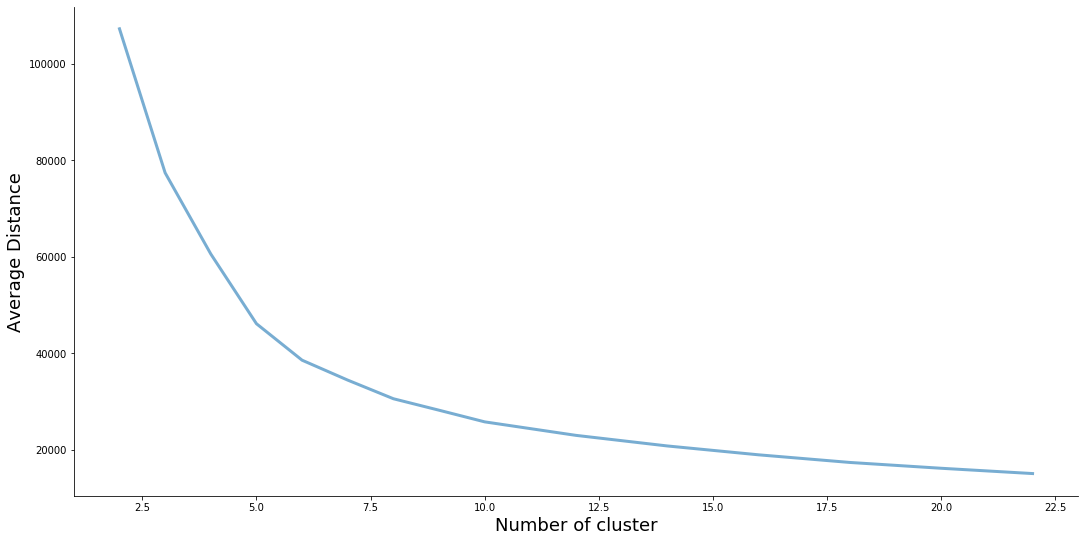

In [13]:
# run k-means over different cluster counts to see the best number of groups to split our demographic data into
# creates plot
fig, ax = plt.subplots(figsize=(18,9))

# loop through all of the different cluster counts
ad = {}
cluster_counts = [2,3,4,5,6,7,8,9,10,12,14,16,18,20,22]
for x in cluster_counts:
    kmeans = KMeans(n_clusters=x, max_iter=1000).fit(input_demo_data)
    ad[x] = kmeans.inertia_
    
# plot the average distance to the center of the clusters 
ax.plot(list(ad.keys()), list(ad.values()), linewidth=3, alpha=0.6)

# label axis
ax.set_xlabel("Number of cluster", fontsize=18)
ax.set_ylabel("Average Distance", fontsize=18)

# Removes spines and changes layout to tight
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# show plot
plt.show()

Plotting the average distance to centroid  by the number of clusters is the best way to determine what the optimum number of cluster should be. This optimum point is called the 'knee' of the graph and shows where the most amount of information gain for the least amount of clusters are. On the graph above we can see a relatively clear knee at around 6 clusters and another small one at 8 where there are changes in information. I've decided to use 8 clusters as the biggest deciding factor on splitting clusters was found be 'Gender' probably as it's a categorical variable. Having a larger number of clusters means I get some splits on other features such as 'Income' and 'age' also.

In [14]:
# create and run the model
final_kmeans = KMeans(n_clusters=8, max_iter=1000).fit(input_demo_data)
predict = final_kmeans.predict(input_demo_data)

# add the pedictions for the clustering onto the original dataset
demographics_output = demographics_input
demographics_output['cluster'] = predict

We can now use the model to predict which clusters users will be grouped into as shown above. I have performed an in depth analysis below into how each of the clusters has been split out.

### Demographics Analysis

In [15]:
demographics_output.groupby('cluster').mean()

,female,male,other,unknown gender,age,income,spend per trans,spend per day,membership length
cluster,,,,,,,,,
0,1.000000,0.000000,0.0,0.0,63.543339,86675.210793,23.015243,4.325650,88.242833
1,0.000000,1.000000,0.0,0.0,60.444397,81426.005133,22.092649,4.466201,75.070145
2,0.000000,0.000000,0.0,1.0,0.000000,0.000000,2.352779,0.452499,70.869565
3,0.502793,0.497207,0.0,0.0,56.983240,79050.279330,129.113700,25.947760,81.608939
4,0.000000,0.000000,1.0,0.0,54.507614,62649.746193,14.529618,3.232132,71.472081
5,1.000000,0.000000,0.0,0.0,50.920623,54080.463936,10.276919,2.026003,56.531714
6,0.032294,0.967706,0.0,0.0,49.905902,54699.331849,7.968539,1.945205,178.811804
7,0.000000,1.000000,0.0,0.0,47.616538,50965.775668,5.885533,1.084990,35.041469


In [59]:
demographics_output.groupby('cluster')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,2965.0,86675.210793,16652.195756,33000.0,74000.0,86000.0,99000.0,120000.0
1,2338.0,81426.005133,17278.182796,31000.0,70000.0,81000.0,93000.0,120000.0
2,2070.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,179.0,79050.279330,17596.371480,36000.0,67000.0,76000.0,91000.0,119000.0
4,197.0,62649.746193,18739.191781,30000.0,50000.0,60000.0,78000.0,100000.0
5,2759.0,54080.463936,13880.147615,30000.0,42000.0,54000.0,64000.0,98000.0
6,1796.0,54699.331849,15180.540967,30000.0,42000.0,54000.0,65000.0,100000.0
7,4003.0,50965.775668,12993.446925,30000.0,40000.0,51000.0,61000.0,98000.0


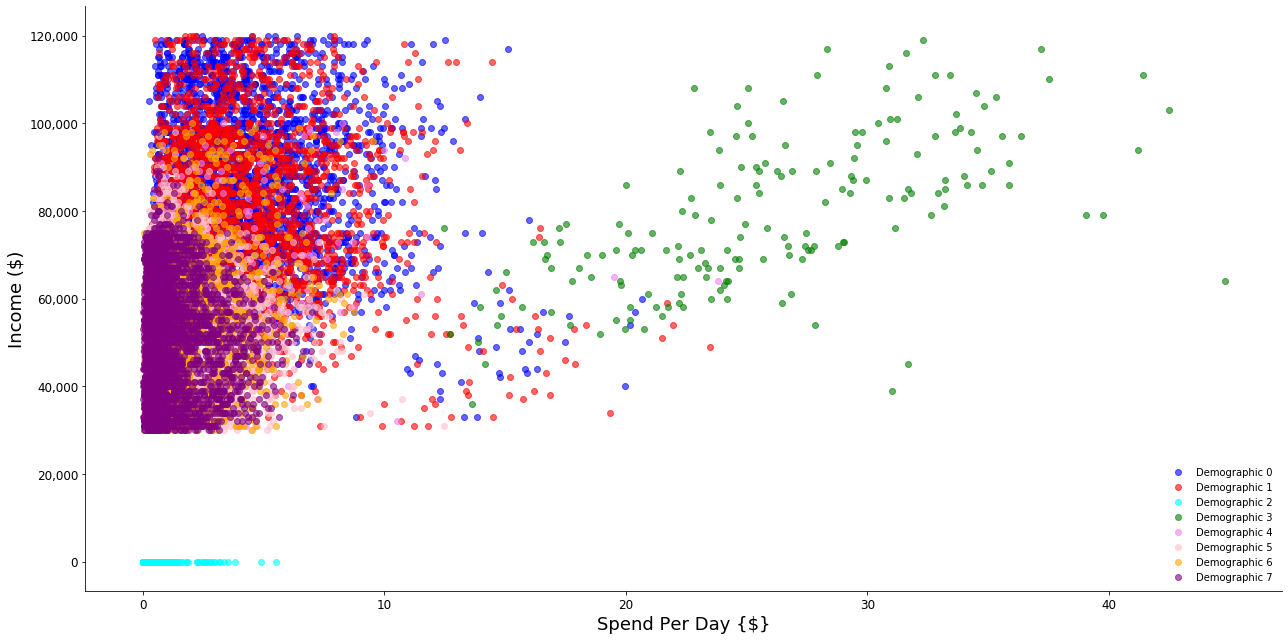

In [56]:
# creates plot
fig, ax = plt.subplots(figsize=(18,9))

for demographic in [0,1,2,3,4,5,6,7]:
    # input data 
    df = demographics_output[demographics_output['cluster'] == demographic]

    # creates a list of colors
    colors = ['blue','red','cyan','green','violet','pink','orange','purple']

    # plot selected demographics
    ax.scatter(df['spend per day'], df['income'], 
               color=colors[demographic], label=f'Demographic {demographic}',
              alpha=0.6)
    
# show the plot legend
ax.legend(loc=4, frameon=False)

# set x label
ax.set_xlabel('Spend Per Day {$}', fontsize=18)

# set y label
ax.set_ylabel('Income ($)', fontsize=18)

# set size of the axis params
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# Adds the comma into y labels
ax.get_yaxis().set_major_formatter(
ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Removes spines and changes layout to tight
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# show/close
plt.show()

In [58]:
demographics_output.groupby('cluster')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,2965.0,63.543339,13.621692,19.0,54.0,62.0,73.0,101.0
1,2338.0,60.444397,13.991031,18.0,52.0,60.0,70.0,100.0
2,2070.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,179.0,56.983240,16.848124,18.0,46.5,58.0,67.5,97.0
4,197.0,54.507614,16.537101,20.0,43.0,55.0,67.0,100.0
5,2759.0,50.920623,17.723888,18.0,37.0,51.0,63.0,101.0
6,1796.0,49.905902,17.555310,18.0,37.0,50.0,63.0,98.0
7,4003.0,47.616538,17.498671,18.0,33.0,47.0,61.0,98.0


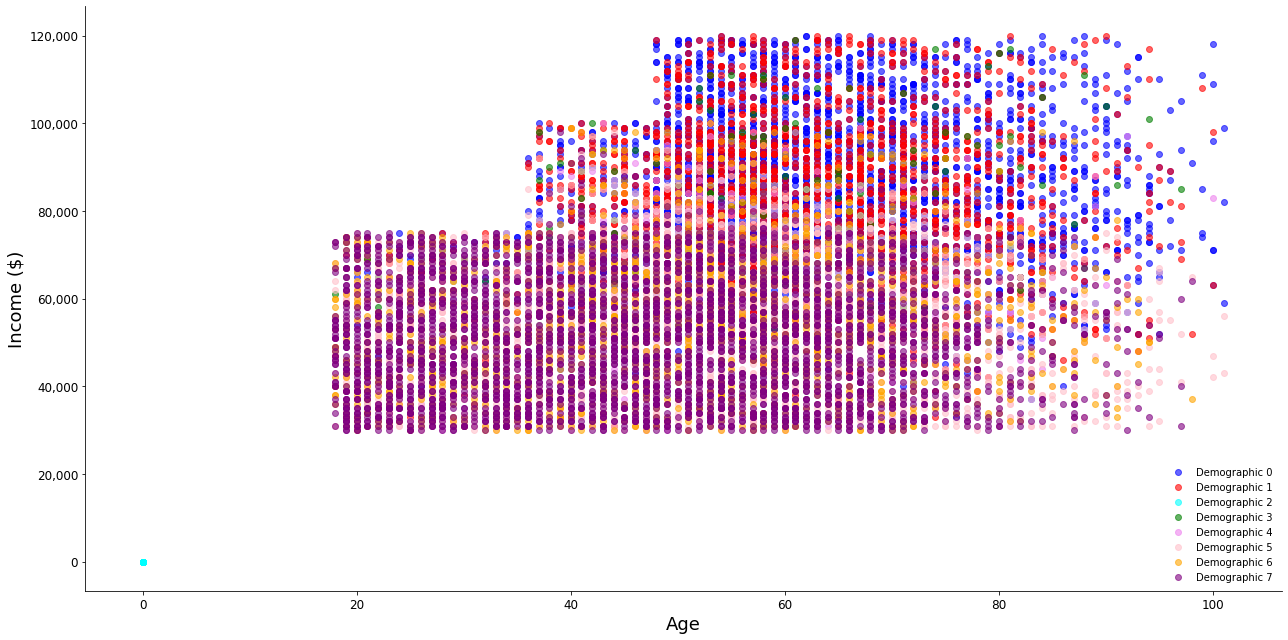

In [57]:
# creates plot
fig, ax = plt.subplots(figsize=(18,9))

for demographic in [0,1,2,3,4,5,6,7]:
    # input data 
    df = demographics_output[demographics_output['cluster'] == demographic]

    # creates a list of colors
    colors = ['blue','red','cyan','green','violet','pink','orange','purple']

    # plot selected demographics
    ax.scatter(df['age'], df['income'], 
               color=colors[demographic], label=f'Demographic {demographic}',
              alpha=0.6)
    
# show the plot legend
ax.legend(loc=4, frameon=False)

# set x label
ax.set_xlabel('Age', fontsize=18)

# set y label
ax.set_ylabel('Income ($)', fontsize=18)

# set size of the axis params
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# Adds the comma into y labels
ax.get_yaxis().set_major_formatter(
ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Removes spines and changes layout to tight
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# show/close
plt.show()

Above shows that we have 8 clusters with the majority being divided primarily on Gender as only two of the clusters contain users with mixed genders. Other key dividing features in the data appear to be spend, age and income.

There are two clusters with males only 1 & 7 respectively. They appear to have been split on all of the three factors above of spend, age and income. This makes sense as younger people tend to have a lower income and therefore will probably spend less on Starbucks coffee. Similarly there are two clusters for women that are split along similar lines (spend, age and income) these are clusters 0 & 5.

Users who put 'other' or have an unknown gender have been put into separate clusters of their own 4 and 2 respectively. It's worth noting that users who didn't specify their gender had very little spend at all this could be because they aren't as engaged users who haven't filled in their personal information.

Finally there are two mixed clusters with both men & women in number 3 & 6. Cluster number 3 appears to show very well off but high spending users. Whereas cluster 6 appears to show young, lower earning users who have had membership for a long time. This could indicate that they are regular customers who spend an average amount each week.

### Output the demographics model

Now that we have our demographic model we can save it and create a function to preform the clustering on any new dataset provided but also to use in future notebooks.

In [60]:
joblib.dump(final_kmeans, 'kmeans_demographic_model.pkl')

['kmeans_demographic_model.pkl']

In [61]:
# Create a function below to read in the model and predict the demographic for other datasets
def predict_demographic(profile_data, demographic_model='kmeans_demographic_model.pkl'):
    """
    this can be used to predict the demographics of group of consumers
    """
    # Reads the volume model 
    final_kmeans = joblib.load(demographic_model)
    
    # remove unwanted columns
    profile_data_input = profile_data.drop(columns=['member joined',
                                              'person', 
                                              'total transactions', 
                                              'total spend'])
    
    # process the profile data
    scaler = StandardScaler()
    scaler.fit(profile_data_input)
    input_demo_data = scaler.transform(profile_data_input)
    
    # predict the demographics   
    predictions = final_kmeans.predict(input_demo_data)
    
    # add the pedictions for the clustering onto the original dataset
    updated_dataframe = profile_data
    updated_dataframe['demographic'] = predictions
    
    return updated_dataframe